# 타격 결과 예측 with SVM

**Support Vector Machines**은 기계학습 방법 중에서 상대적으로 적은 양의 데이터셋으로도 좋은 결과를 얻을 수 있는 모델이다. 야구에서 타자가 친 타구의 결과가 어떠한지 예측하는 SVM 모델을 만들어보았다. 


- **1. [Importing MLB Data](#mlb-data)**
    - Pybaseball 라이브러리를 통해 21시즌 MLB Statcast 데이터를 불러왔다.
    - 모든 투구 데이터 중 타격이 이루어진 데이터를 추출하고, 예측에 사용할 독립변수(타구 속도, 타구 각도, 타구 거리, 각도)를 계산하고, 종속변수(아웃, 1루타, 2루타, 3루타, 홈런)를 numeric value로 분류하였다.
    
   
- **2. [Missing Data](#missing-data)**
    - Missing Data를 확인하고 이를 제거하였다.
       

- **3. [Formatting the Data for Support Vector Machines](#format-the-data)**
    - 데이터를 적절한 수로 downsampling하였다.
    - sampling된 데이터를 독립변수(X)와 종속변수(y)로 나누었다.
    - X와 y를 각각 모델을 학습시키는데 사용할 Train Data와 테스트하는데 사용할 Test Data로 분류하였다.
    - 범위와 수치가 제각각인 독립변수들을 같은 scale로 표준화하였다. 
    
          
- **4. [Building a Support Vector Machine](#build-svm)**
    - Train Data로 모델을 생성하였고, Test Data로 모델을 검증하였다.
    - Confusion Matrix로 모델 예측 결과를 시각화하였다.
     
        
- **5. [Opimizing Parameters with Cross Validation](#optimize-svm)**
    - 더 나은 예측을 하기 위해 SVM 모델 파라미터들을 CrossValidation 방식으로 최적화하였다.
    - 최적화한 모델이 기존 모델과 어떤 차이점이 있는지 비교 분석하였다.

   
- **6. [Testing Final Support Vector Machine Using Specific Pitcher Data](#test-svm)**
    - 최종적으로 학습시킨 SVM 모델을 이용하여 특정 투수의 타구 결과를 예측해보았다.
    - 실제 결과와 예측 결과를 비교할 수 있는 DataFrame과 ConfusionMatrix를 시각화하였다.
    

In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

<a id="mlb-data"></a>
# 1. Importing MLB Data

Pybaseball 라이브러리를 이용하여 21시즌 메이저리그 Statcast 데이터를 불러왔다. 모든 투구 데이터에서 타격이 이루어진 데이터(hit_into_play)를 추출하여 각 타구에 대한 결과를 예측

타구 속도, 타구 각도 데이터와 타구 거리 및 방향을 계산하여 총 4가지의 독립변수를 활용하였다. 종속변수는 타구 결과로서 아웃, 1루타, 2루타, 3루타, 홈런의 4가지로 구분할 수 있도록 분류하였다. 문자열로 구성된 타구 결과를 numeric value로 변경하기 위해 아웃은 0, 1루타는 1, 2루타는 2, 3루타는 3, 홈런은 4로 분류하였다.

### 1-1. 2021 시즌 MLB Statcast 데이터

In [2]:
total=pyb.statcast('2021-01-01', '2021-12-31')

This is a large query, it may take a moment to complete


  0%|          | 0/246 [00:00<?, ?it/s]

Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [03:07<00:00,  1.31it/s]


### 1-2. 모든 타석 결과 중 Hit_into_Play 데이터

In [3]:
hit_into_play = total[total['description']=='hit_into_play']

### 1-3. 모델을 학습시킬 독립변수와 종속변수

- **타구 결과를 예측할 수 있는 독립변수 = (타구 각도, 타구 속도, 타구 거리, 타구 방향)**
    - 타구 각도: launch_angle
    - 타구 속도: launch_speed
    - 타구 위치: hc_x, hc_y
        - 타구 거리: 홈플레이트에서 타구 위치까지의 거리 계산
        - 타구 각도: 홈플레이트 기준으로 hc_x, hc_y 사이의 각도 계산


- **종속변수 = hit = ['single', 'double', 'triple', 'home_run']**
    - 'out' = 0
    - 'signle' = 1
    - 'double' = 2
    - 'triple' = 3
    - 'home_run' = 4

In [4]:
# 종속 변수 Column 'hit' 생성
hit = ['single', 'double', 'triple', 'home_run']
hit_into_play['hit'] = np.where(hit_into_play['events']=='single', 1, 0)
hit_into_play['hit'] = np.where(hit_into_play['events']=='double', 2, hit_into_play['hit'])
hit_into_play['hit'] = np.where(hit_into_play['events']=='triple', 3, hit_into_play['hit'])
hit_into_play['hit'] = np.where(hit_into_play['events']=='home_run', 4, hit_into_play['hit'])

# 학습에 필요한 독립 변수들만 추출
df = hit_into_play[['launch_angle', 'launch_speed', 'hc_x', 'hc_y', 'hit']]

In [5]:
# 홈플레이트 좌표를 이용하여 타구 거리와 각도 계산
home_x = 126
home_y = 204
df['distance'] = np.sqrt((df['hc_x']-home_x)**2 + (df['hc_y']-home_y)**2)
df['angle'] = df['distance']/(home_y-df['hc_y'])

In [6]:
df.head()

,launch_angle,launch_speed,hc_x,hc_y,hit,distance,angle
113,-28,93.8,98.12,136.43,0,73.095823,1.081779
133,39,92.7,68.50,86.79,0,130.554334,1.113850
180,24,93.1,173.40,72.81,0,139.490416,1.063270
215,13,103.4,175.56,102.42,1,113.025174,1.112672
184,-13,78.5,159.51,167.83,0,49.307089,1.363204


----

<a id="missing-data"></a>
# 2. Missing Value

데이터 중 기록되지 않은 missing value를 처리하였다. 위에서 추출한 데이터 총 123542개 중에서 각 변수들의 missing value는 400개 이하로 0.3%정도 되기 때문에 삭제하였다.

In [7]:
# 총 데이터 수
len(df)

123542

In [8]:
# missing value 수
df.isnull().sum()

launch_angle    393
launch_speed    392
hc_x             83
hc_y             83
hit               0
distance         83
angle            83
dtype: int64

In [9]:
# drop missing value
df = df[df['launch_angle'].notnull() & df['launch_speed'].notnull() & df['distance'].notnull() & df['angle'].notnull()]

----

<a id="format-the-data"></a>
# 3. Formatting the Data for Support Vector Machines

SVM은 비교적 적은 데이터로 학습시키기에 좋은 기계 학습 모델이다. 10만개가 넘는 데이터를 SVM에 학습시킬 경우 Overfitting이 발생할 수 있기 때문에 적절한 수로 downsampling을 수행하였다. 3루타를 제외하고는 모든 결과에 대해 1000개의 데이터를 랜덤 추출하였고, 3루타는 500개를 추출하였다.(총 4500개의 데이터)

downsampling으로 추출한 데이터를 학습에 사용할 데이터(Train Data)와 검증에 사용할 데이터(Test Data)로 구분하였다. 단위나 크기가 제각각인 독립변수들을 같은 스케일을 갖게 하기 위해 StandardScaler 함수를 이용하여 전처리하였다. StandardScaler는 데이터를 평균 0, 분산 1로 표준화해준다.

### 3-1. Downsampling

In [10]:
df_out = df[df['hit']==0]
df_single = df[df['hit']==1]
df_double = df[df['hit']==2]
df_triple = df[df['hit']==3]
df_homerun = df[df['hit']==4]

In [11]:
# downsampling
df_out_downsampled = resample(df_out,replace=False,n_samples=1000,random_state=42)
df_single_downsampled = resample(df_single,replace=False,n_samples=1000,random_state=42)
df_double_downsampled = resample(df_double,replace=False,n_samples=1000,random_state=42)
df_triple_downsampled = resample(df_triple,replace=False,n_samples=500,random_state=42)
df_homerun_downsampled = resample(df_homerun,replace=False,n_samples=1000,random_state=42)

df_downsample = pd.concat([df_out_downsampled, df_single_downsampled, df_double_downsampled, df_triple_downsampled, df_homerun_downsampled])
len(df_downsample)

4500

### 3-2. Split Data into Dependent and Independent Variables

In [12]:
# 독립변수 X, 종속변수 y
X = df_downsample.drop('hit', axis=1).copy()
y = df_downsample['hit'].copy()

In [13]:
# Train Data, Test Data 구분 및 데이터 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

----

<a id="build-svm"></a>
# 4. Building a Support Vector Machine

위에서 만든 학습에 사용할 종속변수와 독립변수 데이터(X_train, y_train)를 이용하여 SVC 모델을 학습시켰다. 학습시킨 후 테스트 데이터(X_test, y_test)를 모델에 적용시켜 결과를 확인해보았다. 결과 확인은 confusion matrix를 이용하였고, 표를 통해 실제 값과 예측 값의 차이를 확인할 수 있었다. 

특징적인 부분은 3루타에 대한 예측이 꽤나 저조하다는 것이었다. 타구 결과가 아웃, 1루타, 2루타, 홈런인 경우는 준수하게 예측하는 반면 3루타의 경우, 2루타나 홈런으로 잘못 예측하는 경우가 많았다. 이를 최대한 줄이기 위해 아래에 SVM 모델에 사용되는 파라미터들을 최적화하였다. 

### 4-1. Training Model using Training Data

In [14]:
# building model
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

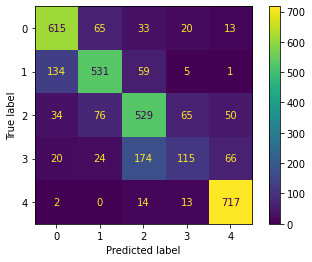

In [15]:
# confusion matrix로 결과 확인
plot_confusion_matrix(clf_svm, X_train_scaled, y_train)

### 4-2. Testing Data

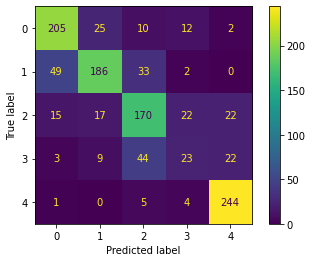

In [16]:
# Test Data로 모델 검증
plot_confusion_matrix(clf_svm, X_test_scaled, y_test)

----

<a id="optimize-svm"></a>
# 5. Opimizing Parameters with Cross Validation

SVM 모델 최적화는 파라미터인 C와 gamma값에 대한 최적의 수치를 찾아가는 것이다. Cross Validation으로 더 나은 파라미터들을 발견해서 Test Data에 대한 예측이 더 나아지는지 확인해보았다. 

파라미터 C와 gamma 몇가지 value에 대한 리스트를 만든 후, GridSearchCV를 이용하여 어떤 value가 최적의 값인지 확인할 수 있도록 하였다. GridSearchCV를 수행한 결과 C=10, gamma=1이라는 최적의 값을 얻을 수 있었고, 이를 SVC에 새롭게 적용하여 다시 test data로 검증해보았다.
   
처음 SVC를 학습시켰을 때와 가장 눈에 띄는 부분은 3루타 예측 정확성이었다. 첫 SVC 모델은 총 101개의 3루타 중 정확하게 예측한 것이 12개인데 반면, 최적화한 SVC는 26개를 제대로 예측하였다. 최적화로 인해서 3루타 예측 정확도가 2배 이상의 성능을 가지는 것을 확인하였다.
   
그러나, 여전히 101개 중 26개를 예측한 수치는 낮은 예측률이었다. 기존보다 좋아지기는 하였지만, 여전히 실제 3루타 중 많은 비중을 2루타나 홈런으로 잘못 예측하는 모습을 보여주었다. 이는 3루타가 2루타와 홈런에 비해 데이터로써의 큰 차이를 가지지 않기 때문이라고 해석할 수 있다. 수비수의 실책과 같은 데이터로 표현되지 않는 부분이 3루타를 만들어내는데 영향을 미치는 것임을 알 수 있다.

In [17]:
param_grid = [
  {'C': [0.5, 1, 10, 100],
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

In [18]:
optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        verbose=0
    )

In [19]:
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [20]:
clf_svm = SVC(random_state=42, C=10, gamma=1)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=1, random_state=42)

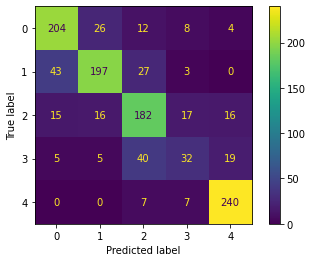

In [21]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      )

----

<a id="test-svm"></a>
# 6. Testing Final Support Vector Machine Using Specific Pitcher Data

최적화된 SVM 모델을 특정 선수 데이터에 적용하여 예측 결과를 확인해보았다. 특정 선수 데이터를 통해 실제 타구 결과와 예측 결과를 비교할 수 있는 DataFrame과 ConfusionMatrix를 만들어보았다.
    
모델의 예측 결과들의 특징을 살펴보면, 실제로는 아웃인데 안타(1루타, 2루타, 3루타, 홈런)로 예측하는 비중이 대체로 높았다.

### 6-1 함수 생성

In [63]:
def predict_outcome(player):
    player_hit = player[player['description']=='hit_into_play']
    player_hit = player_hit[player_hit['launch_angle'].notnull() & player_hit['launch_speed'].notnull() & player_hit['hc_x'].notnull() & player_hit['hc_y'].notnull()]

    player_hit['hit'] = np.where(player_hit['events']=='single', 1, 0)
    player_hit['hit'] = np.where(player_hit['events']=='double', 2, player_hit['hit'])
    player_hit['hit'] = np.where(player_hit['events']=='triple', 3, player_hit['hit'])
    player_hit['hit'] = np.where(player_hit['events']=='home_run', 4, player_hit['hit'])

    player_hit['distance'] = np.sqrt((player_hit['hc_x']-home_x)**2 + (player_hit['hc_y']-home_y)**2)
    player_hit['angle'] = player_hit['distance']/(home_y-player_hit['hc_y'])
    player_test = player_hit[['launch_angle', 'launch_speed', 'hc_x', 'hc_y', 'distance', 'angle', 'hit']]

    player_x_test = player_test.drop('hit', axis=1).copy()
    player_x_test_scaled = scaler.transform(player_x_test)

    player_test['predict'] = clf_svm.predict(player_x_test_scaled)
    
    player_hit_count = player[player['events'].isin(hit)]

    player_hit_real = player_hit_count['events'].value_counts().reset_index().rename(columns={'index': 'hit', 'events': 'real'})
    player_hit_predict = player_test['predict'].value_counts().reset_index()
    player_hit_predict['hit']=''
    for i in range(len(player_hit_predict)):
        if player_hit_predict['index'][i]==0:
            player_hit_predict['hit'][i]='out'
        elif player_hit_predict['index'][i]==1:
            player_hit_predict['hit'][i]='single'
        elif player_hit_predict['index'][i]==2:
            player_hit_predict['hit'][i]='double'
        elif player_hit_predict['index'][i]==3:
            player_hit_predict['hit'][i]='triple'
        else:
            player_hit_predict['hit'][i]='home_run'
    player_hit_predict.drop('index', axis=1, inplace=True)

    hit_order=['single', 'double', 'triple', 'home_run']
    compare = pd.merge(player_hit_real, player_hit_predict, on='hit', how='left').set_index('hit').reindex(hit_order).fillna(0)
    compare['predict'] = compare['predict'].astype(int)
    compare.loc['total'] = compare.iloc[:, :].sum()
    
    player_hit['events'] = np.where(player_hit['hit']==0, 'out', player_hit['events'])
    predict=player_test.copy()
    predict['events'] = np.where(predict['predict']==0, 'out', '')
    predict['events'] = np.where(predict['predict']==1, 'single', predict['events'])
    predict['events'] = np.where(predict['predict']==2, 'double', predict['events'])
    predict['events'] = np.where(predict['predict']==3, 'triple', predict['events'])
    predict['events'] = np.where(predict['predict']==4, 'home_run', predict['events'])
    predict.sort_values(by='events', inplace=True)
    player_hit.sort_values(by='events', inplace=True)
    pyb.spraychart(player_hit, 'blue_jays', title=player['player_name'].unique() + ' 2021 REAL hit')
    pyb.spraychart(predict, 'blue_jays', title=player['player_name'].unique() + ' 2021 PREDICT hit')
    
    return compare, plot_confusion_matrix(clf_svm,player_x_test_scaled,player_test['hit'])

    
    
    
    

### Example 1. 류현진 선수

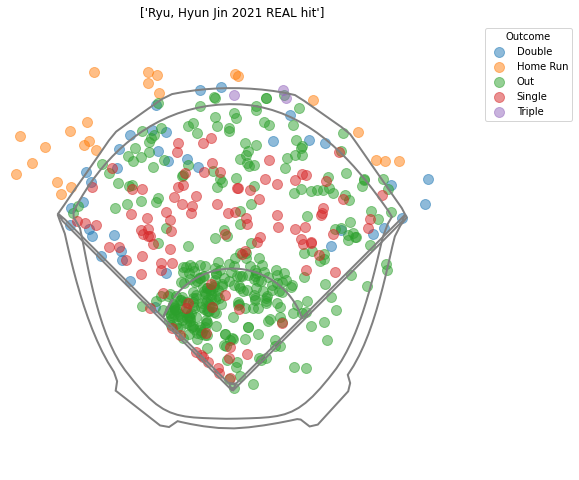

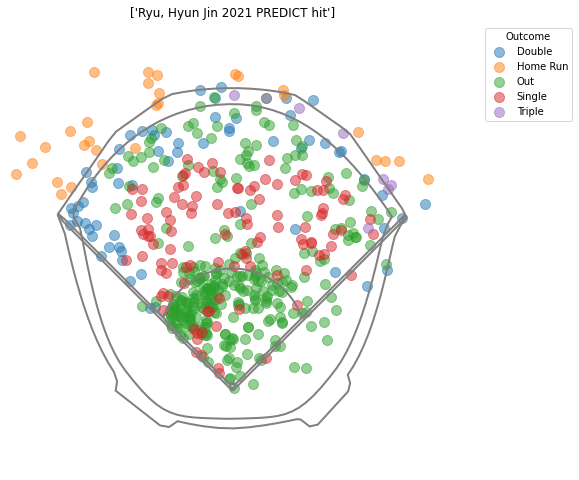

(          real  predict
 hit                    
 single     105      107
 double      38       63
 triple       3        8
 home_run    24       30
 total      170      208,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x28fd722e1c0>)

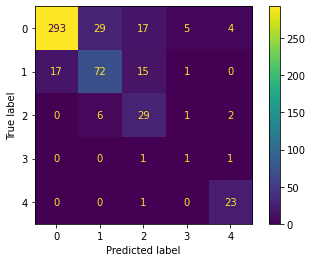

In [64]:
ryu = total[(total['player_name']=='Ryu, Hyun Jin')]
predict_outcome(ryu)

### Example 2. Jacob deGrom

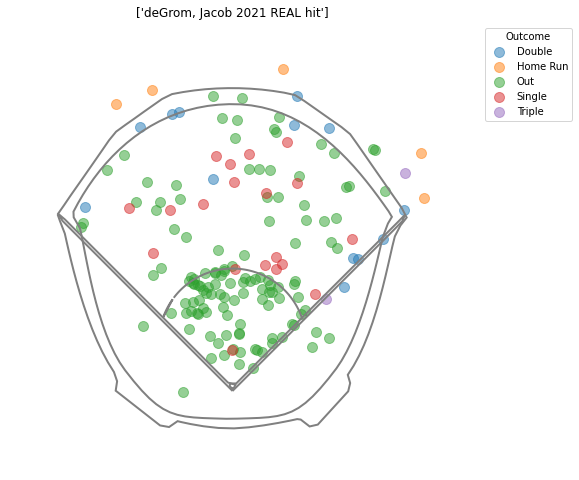

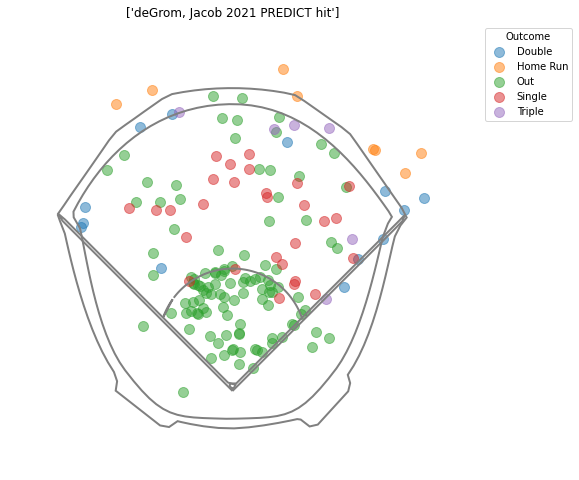

(          real  predict
 hit                    
 single      19       28
 double      13       13
 triple       2        6
 home_run     6        8
 total       40       55,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x28f8c2796d0>)

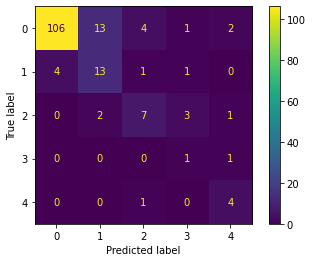

In [65]:
degrom = total[(total['player_name']=='deGrom, Jacob')]
predict_outcome(degrom)

### Example 3. Darvish Yu

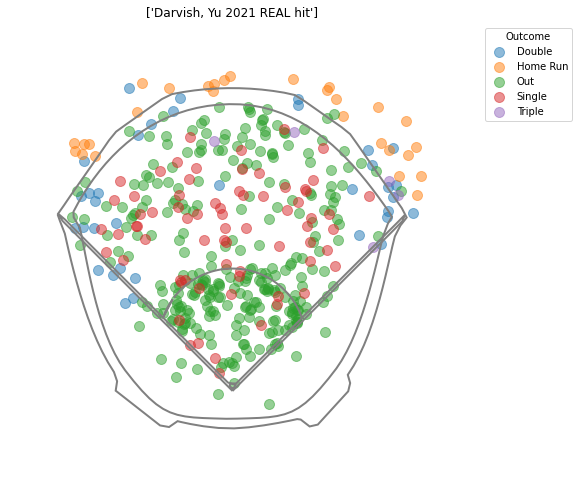

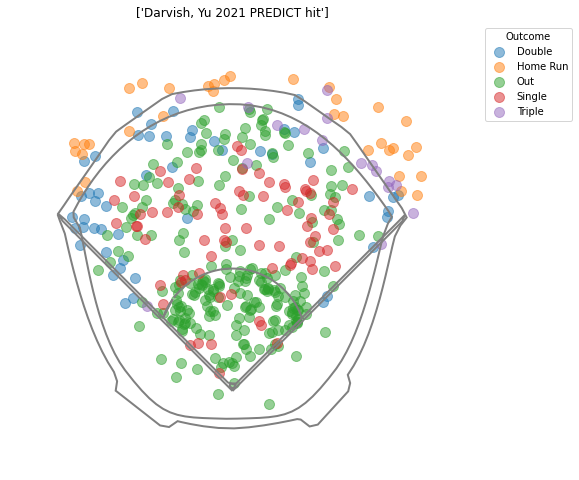

(          real  predict
 hit                    
 single      70       76
 double      35       51
 triple       5       17
 home_run    28       34
 total      138      178,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x28f8c71ebb0>)

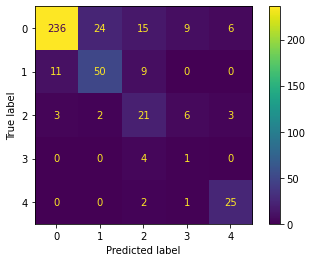

In [66]:
darvish = total[(total['player_name']=='Darvish, Yu')]
predict_outcome(darvish)